# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


In [ ]:
# import os

# os.chdir("/content/drive/MyDrive/GAN_747")


In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


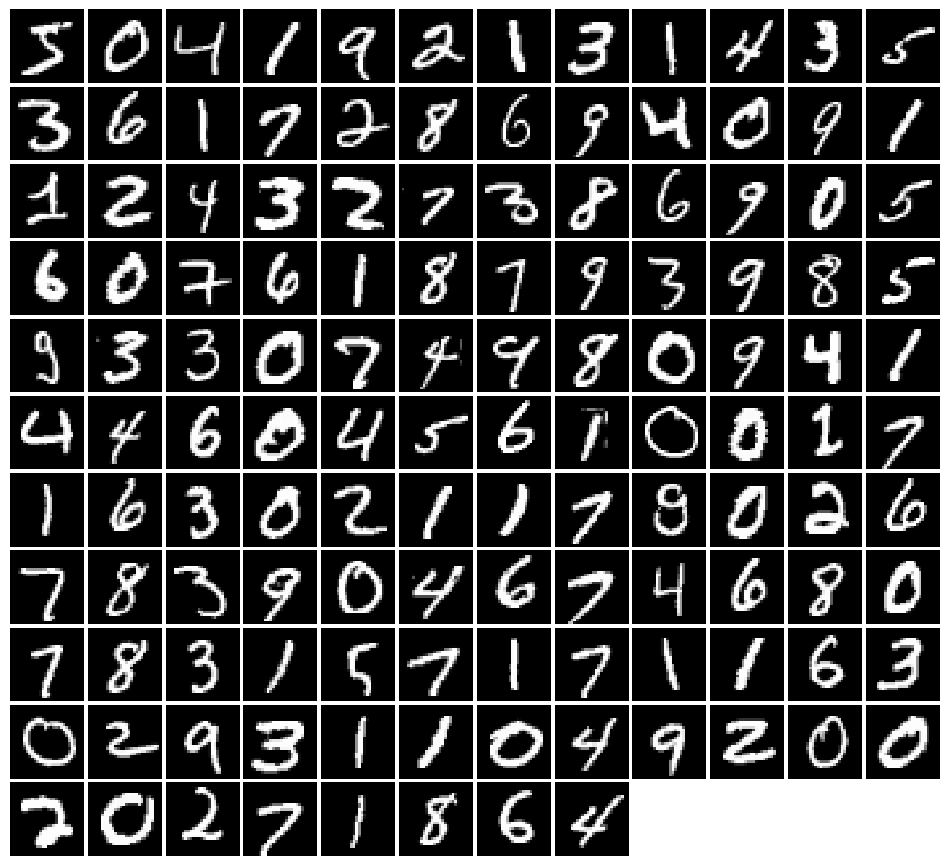

In [34]:
NOISE_DIM = 100
batch_size = 128
img_size = 28

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs_iter = loader_train.__iter__()
imgs = next(imgs_iter)[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [7]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [8]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 0.5565, G:0.7146


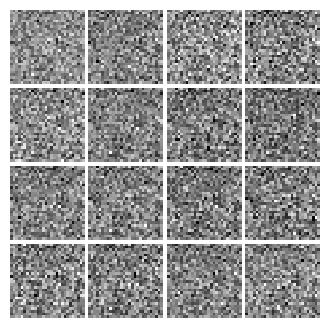


Iter: 250, D: 0.439, G:0.3714


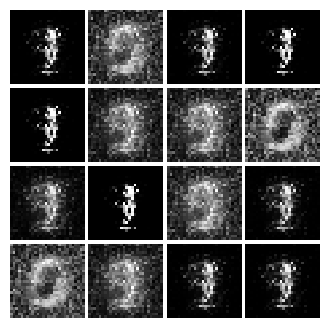


EPOCH:  2
Iter: 500, D: 0.3852, G:0.783


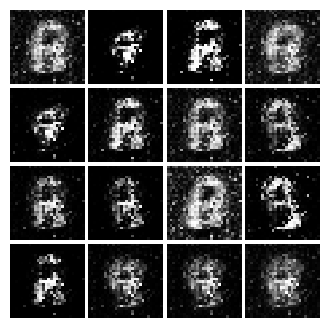


Iter: 750, D: 0.4723, G:0.5492


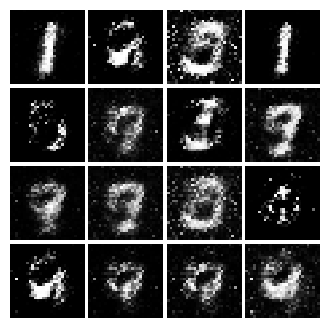


EPOCH:  3
Iter: 1000, D: 0.3137, G:0.9954


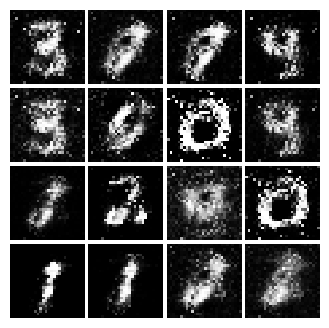


Iter: 1250, D: 0.424, G:0.6977


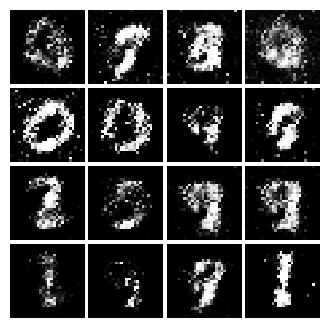


EPOCH:  4
Iter: 1500, D: 0.329, G:0.845


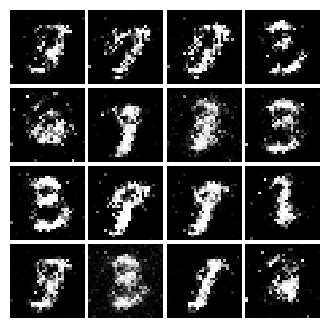


Iter: 1750, D: 0.4398, G:0.7317


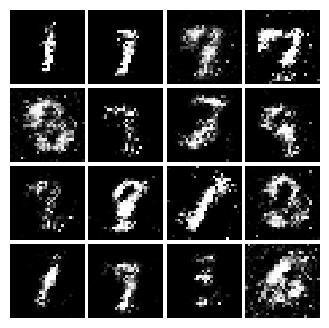


EPOCH:  5
Iter: 2000, D: 0.3782, G:0.7302


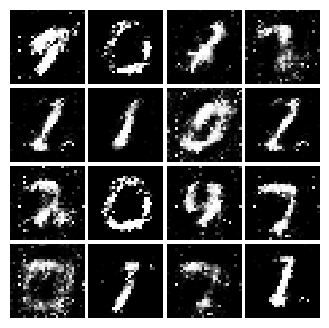


Iter: 2250, D: 0.3909, G:0.6598


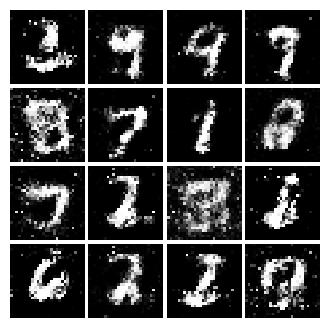


EPOCH:  6
Iter: 2500, D: 0.4615, G:0.6373


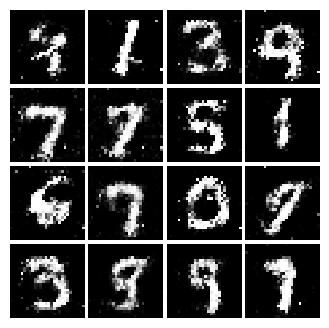


Iter: 2750, D: 0.4425, G:0.5947


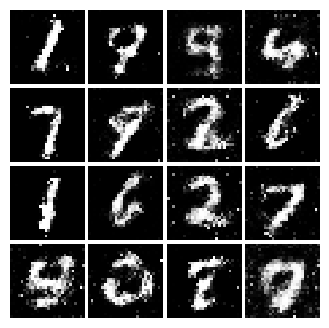


EPOCH:  7
Iter: 3000, D: 0.4527, G:0.5892


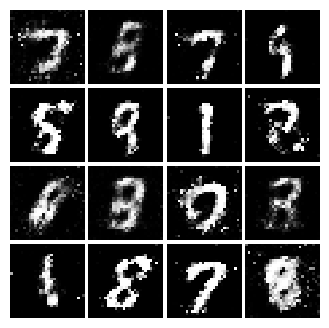


Iter: 3250, D: 0.3802, G:0.6377


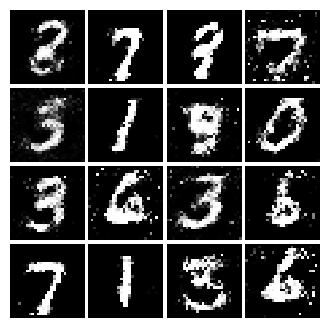


EPOCH:  8
Iter: 3500, D: 0.4523, G:0.6198


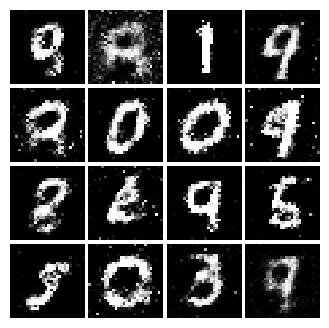


EPOCH:  9
Iter: 3750, D: 0.4193, G:0.6082


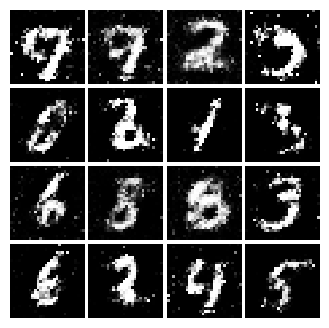


Iter: 4000, D: 0.4402, G:0.6353


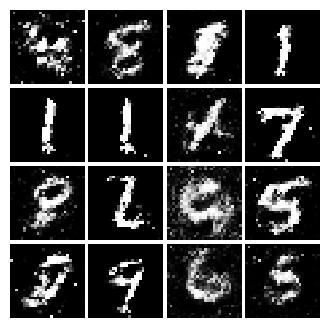


EPOCH:  10
Iter: 4250, D: 0.4434, G:0.57


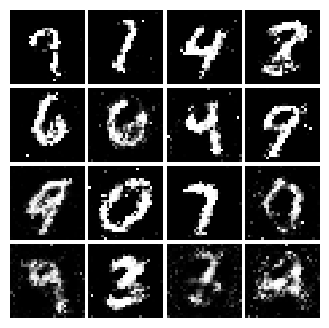


Iter: 4500, D: 0.4597, G:0.5654


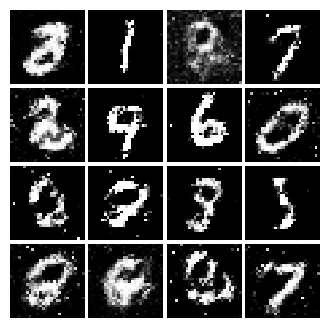

In [46]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.4245, G:1.028


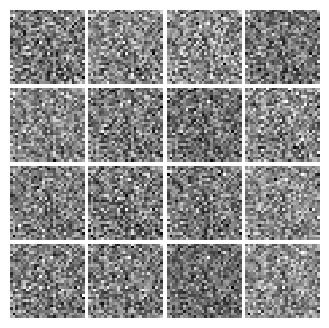


Iter: 250, D: 0.07978, G:0.7553


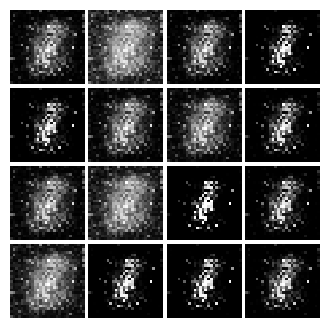


EPOCH:  2
Iter: 500, D: 0.08388, G:1.1


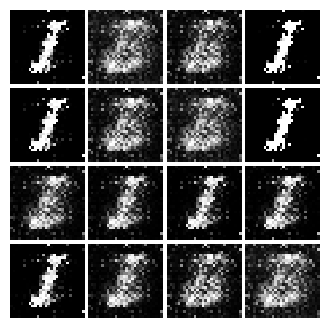


Iter: 750, D: 0.139, G:0.6615


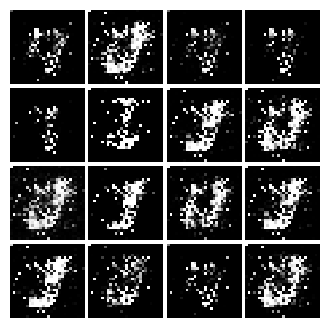


EPOCH:  3
Iter: 1000, D: 0.1665, G:0.5419


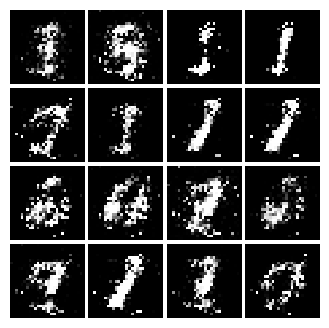


Iter: 1250, D: 0.1242, G:0.73


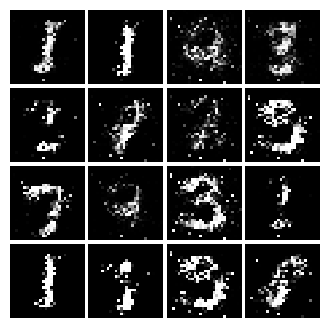


EPOCH:  4
Iter: 1500, D: 0.361, G:0.3165


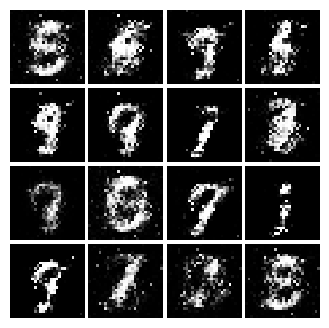


Iter: 1750, D: 0.1915, G:0.2147


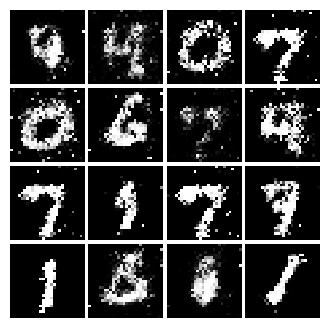


EPOCH:  5
Iter: 2000, D: 0.2021, G:0.3919


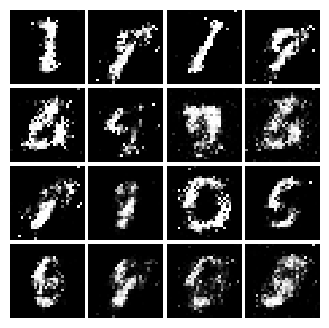


Iter: 2250, D: 0.1871, G:0.3668


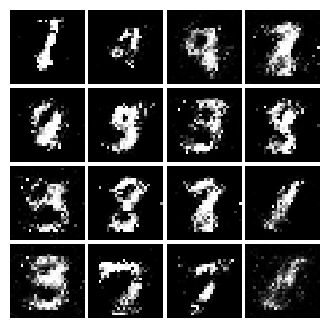


EPOCH:  6
Iter: 2500, D: 0.1878, G:0.3573


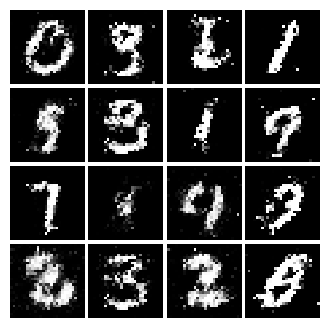


Iter: 2750, D: 0.2477, G:0.3315


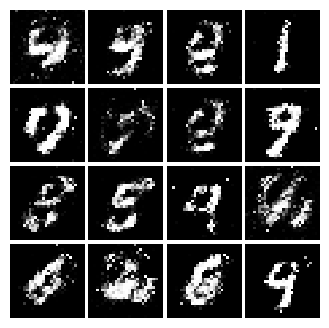


EPOCH:  7
Iter: 3000, D: 0.1896, G:0.3511


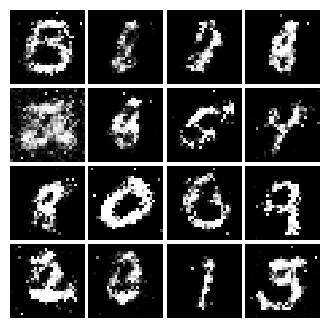


Iter: 3250, D: 0.1976, G:0.363


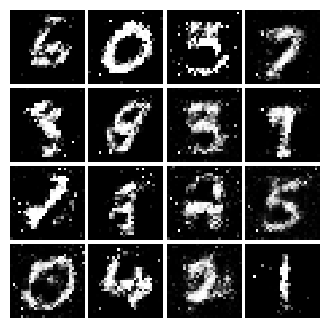


EPOCH:  8
Iter: 3500, D: 0.2419, G:0.3646


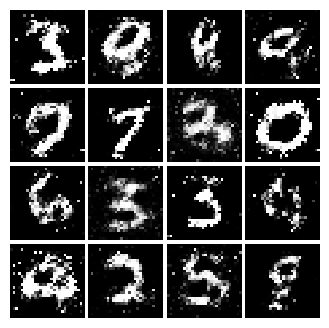


EPOCH:  9
Iter: 3750, D: 0.2162, G:0.3821


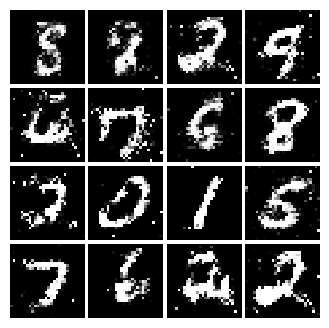


Iter: 4000, D: 0.2397, G:0.3735


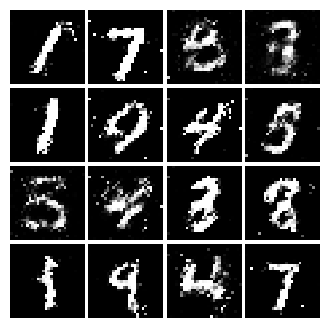


EPOCH:  10
Iter: 4250, D: 0.2129, G:0.3084


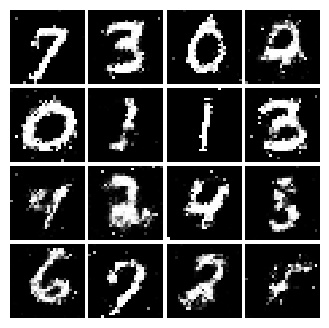


Iter: 4500, D: 0.2394, G:0.2959


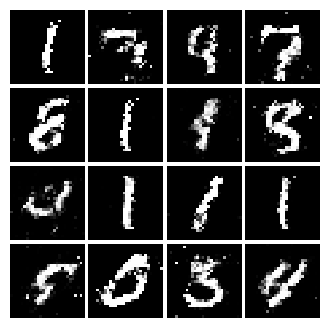

In [50]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)